In [13]:
import tensorflow as tf
from keras.layers import LSTM, Dropout, Flatten, Dense, MaxPooling2D, Embedding, Bidirectional, Input
from keras.models import Sequential, Model
import pickle
import numpy as np
from keras.layers import Conv2D, Add, ConvLSTM2D, Reshape, BatchNormalization
from keras.optimizers import Adam, schedules


In [2]:
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.7)

tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

In [3]:
with open('processed_data/X_train.pickle', 'rb') as f:
  X_train = pickle.load(f)

with open('processed_data/X_valid.pickle', 'rb') as f:
  X_valid = pickle.load(f)

with open('processed_data/X_test.pickle', 'rb') as f:
  X_test = pickle.load(f)

In [4]:
with open('processed_data/y_train.pickle', 'rb') as f:
  y_train = pickle.load(f)

with open('processed_data/y_valid.pickle', 'rb') as f:
  y_valid = pickle.load(f)
 
with open('processed_data/y_test.pickle', 'rb') as f:
  y_test = pickle.load(f)

In [5]:
X_train.shape

(15373, 128, 513, 1)

In [6]:
models_input = Input(shape=X_train[0].shape)

In [7]:
cnn_model = Sequential()
cnn_model.add(models_input)

cnn_model.add(Conv2D(filters=16, kernel_size=2, padding='same', strides=(2,2), activation="relu"))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=2))
cnn_model.add(Dropout(0.2))

cnn_model.add(Conv2D(filters=32, kernel_size=3, padding='same', strides=(2,2), activation="relu"))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=2))

cnn_model.add(Conv2D(filters=64, kernel_size=3, padding='same', strides=(2,2), activation="relu"))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=2))
cnn_model.add(Dropout(0.2))

cnn_model.add(Conv2D(filters=128, kernel_size=4, padding='same', activation="relu"))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=2))

cnn_model.add(Conv2D(filters=64, kernel_size=4, padding='same', activation="relu"))
cnn_model.add(BatchNormalization())

cnn_model.add(Flatten())
cnn_model.add(Dropout(0.2))

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 257, 16)       80        
                                                                 
 batch_normalization (BatchN  (None, 64, 257, 16)      64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 128, 16)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 128, 16)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 64, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 16, 64, 32)       1

In [8]:
lstm_model =  Sequential()

lstm_model.add(models_input)
lstm_model.add(MaxPooling2D(pool_size=(1,2),strides=(1,2)))
lstm_model.add(MaxPooling2D(pool_size=(1,2),strides=(1,2)))
lstm_model.add(Reshape((128,128)))

lstm_model.add(Bidirectional(LSTM(units = 128, return_sequences = True)))
lstm_model.add(Bidirectional(LSTM(units = 128)))

lstm_model.add(Flatten())
lstm_model.add(Dropout(0.5))

lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 max_pooling2d_4 (MaxPooling  (None, 128, 256, 1)      0         
 2D)                                                             
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 128, 128, 1)      0         
 2D)                                                             
                                                                 
 reshape (Reshape)           (None, 128, 128)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 128, 256)         263168    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              394240    
 nal)                                                 

In [9]:
mergedModel = Add()([cnn_model.output, lstm_model.output])
mergedModel =  Dense(10,activation='sigmoid')(mergedModel)

model =  tf.keras.models.Model(inputs = models_input,outputs=mergedModel)

opt=Adam(learning_rate=0.005)
model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 513, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 257, 16)  80          ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 257, 16)  64         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [10]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='combined_model_5.best.hdf5',verbose=1,save_best_only = True)
hist = model.fit(X_train,y_train,batch_size=32,epochs=70,validation_data=(X_valid,y_valid),callbacks=[checkpointer],verbose=1,shuffle=True)

Epoch 1/70
481/481 [==============================] - ETA: 0s - loss: 0.2367 - accuracy: 0.4703
Epoch 1: val_loss improved from inf to 0.20427, saving model to combined_model_5.best.hdf5
481/481 [==============================] - 215s 410ms/step - loss: 0.2367 - accuracy: 0.4703 - val_loss: 0.2043 - val_accuracy: 0.5524
Epoch 2/70
481/481 [==============================] - ETA: 0s - loss: 0.1863 - accuracy: 0.5906
Epoch 2: val_loss improved from 0.20427 to 0.19155, saving model to combined_model_5.best.hdf5
481/481 [==============================] - 191s 396ms/step - loss: 0.1863 - accuracy: 0.5906 - val_loss: 0.1915 - val_accuracy: 0.5881
Epoch 3/70
481/481 [==============================] - ETA: 0s - loss: 0.1709 - accuracy: 0.6305
Epoch 3: val_loss improved from 0.19155 to 0.15738, saving model to combined_model_5.best.hdf5
481/481 [==============================] - 194s 403ms/step - loss: 0.1709 - accuracy: 0.6305 - val_loss: 0.1574 - val_accuracy: 0.6712
Epoch 4/70
481/481 [======

In [11]:
model.evaluate(X_test,y_test)

60/60 [==============================] - 13s 209ms/step - loss: 0.0954 - accuracy: 0.8552


[0.095438152551651, 0.855186939239502]

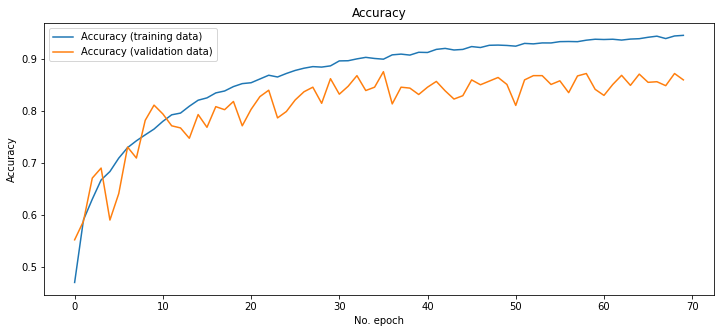

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.plot(hist.history['accuracy'],label='Accuracy (training data)')
plt.plot(hist.history['val_accuracy'],label='Accuracy (validation data)')
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('No. epoch')
plt.legend(loc='best')
plt.show()



In [22]:
model_json=model.to_json()
with open("combined_model.json","w") as json_file:
  json_file.write(model_json)

model.save_weights("combined_model_weights.h5")
print("Saved model to disk")

Saved model to disk
